In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np
import warnings
import glob

In [2]:
directory = 'data/*.csv' 
files = glob.glob(directory)[0]

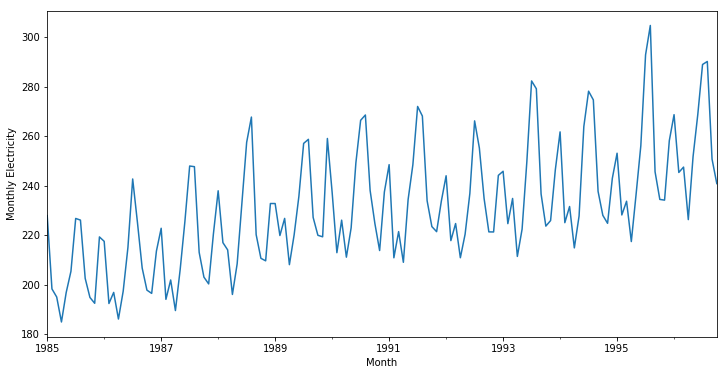

In [3]:
df = wine = pd.read_csv(files, index_col=['Month'], parse_dates=['Month'], dayfirst=True)
df.columns  = ['elctricty']
df['elctricty'].plot(figsize=(12,6))
plt.ylabel('Monthly Electricity')
plt.show()

Ряд не должен быть стационарным - присутствует тренд, в некоторых местах дисперсия непостоянна.

In [4]:
print('Критерий Дики-Фуллера: p=%f' % adfuller(df.elctricty)[1])

Критерий Дики-Фуллера: p=0.854137


## 1. Уберем тренд из ряда

In [5]:
from sklearn.linear_model import LinearRegression
X = np.arange(1,df.shape[0]+1).reshape(-1, 1)
y = df['elctricty'].values;
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
residuals = y_pred - y
df['el_withoud_trend']=residuals

## 2. Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 1.471126
Критерий Дики-Фуллера: p=0.623368


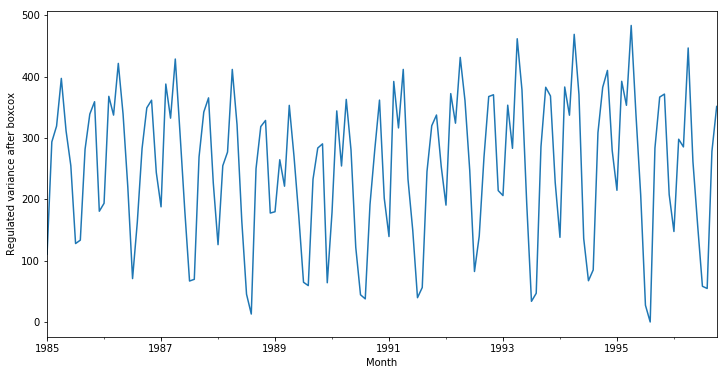

In [6]:
n = abs(min(df.el_withoud_trend))+1
df['elc_boxcox'], lmbda = boxcox(df.el_withoud_trend + n)
df['elc_boxcox'].plot(figsize=(12,6))
plt.ylabel('Regulated variance after boxcox')
print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % adfuller(df.elc_boxcox)[1])

## 3. Дифференцирование ряда

С помощью преобразования boxcox удалось стабилизировать дисперсию. Проведем дифференцирование.

Критерий Дики-Фуллера: p=0.000000


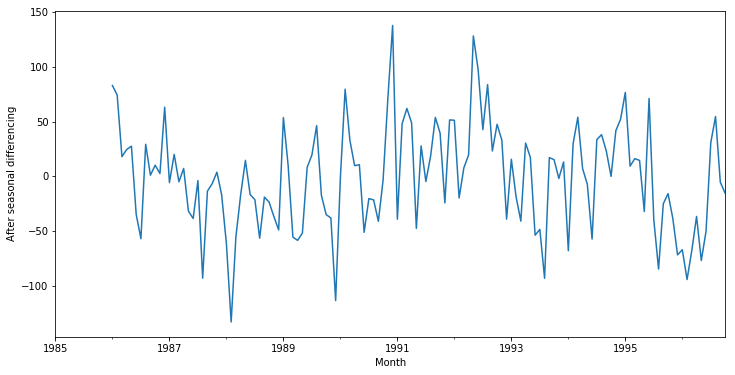

In [7]:
df['sdiff_elec'] =  df.elc_boxcox.diff(12)
df['sdiff_elec'].plot(figsize=(12,6))
plt.ylabel('After seasonal differencing')
print('Критерий Дики-Фуллера: p=%f' % adfuller(df['sdiff_elec'].dropna())[1])

Ряд не является стационарным, видно невооруженным глазоим. Проведем дифференцирование

Критерий Дики-Фуллера: p=0.000917


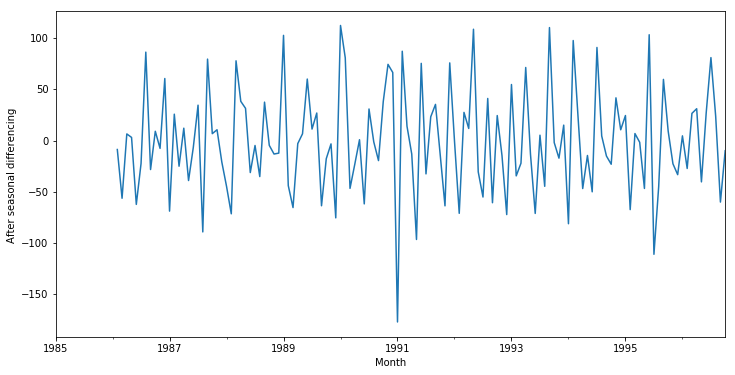

In [8]:
df['one_more_diff'] =  df['sdiff_elec'].diff(1)
df['one_more_diff'].plot(figsize=(12,6))
plt.ylabel('After seasonal differencing ')
print('Критерий Дики-Фуллера: p=%f' % adfuller(df['one_more_diff'].dropna())[1])

А вот теперь и по критерию Дики-фуллера, и по графику видно, что ряд с помощью вычитания тренда, стабилизации дисперсии и двух дифференцирований получился стационарным.


## 4. Выбор гиперпараметров модели

Для выбора порядка авторегрессии обратимся к частичной автокорреляции.

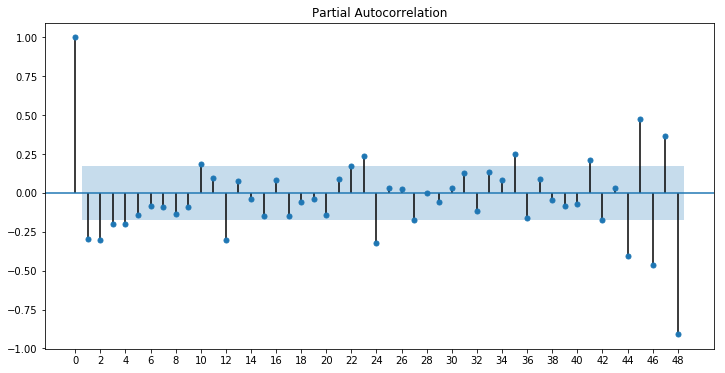

In [9]:
plt.rcParams['figure.figsize'] = (12,6)
plot_pacf(df['one_more_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг оказался равным 0, значит $p_0=4$. Период сезонности составляет 12. При лаге, равном 12, частичная автокорреляция значима, при 24 значима,при 36 нет. Значит, $P_0=2$. Теперь обратимся к автокорреляции для определения порядка скользящего среднего.

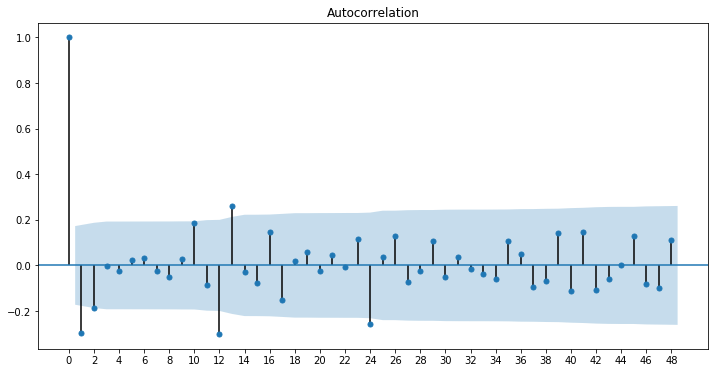

In [10]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(df['one_more_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Посдедний значимый лаг $-$ 2. А последний значимый сезонный лаг равен 1 (при лаге 12 автокорреляция значима, при 24 -  уже нет). Таким образом, $q_0=2, Q_0=2$.

In [11]:
d=1
D=1
p = range(0, 5)
P = range(0, 3)
q = range(0, 3)
Q = range(0, 3)

In [12]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [13]:
len(parameters_list)

135

## 5. Выбор лучшей модели

Рассмотрим все возможные модели и сравним их по критерию Акаике. В ячейке ниже создадим список `results`, куда будем записывать значения гиперпараметров и значение критерия Акаике при данном наборе. В цикле будем строить модель SARIMAX `model` и, если полученное значение критерия Акаике `aic` меньше, чем на предыдущих шагах, запишем эту модель в переменную `best_model`. Во избежание предупреждений statsmodels о необходимости определить частоту наблюдений и плохой сходимости отключим предупреждения.

Модель SARIMAX принимает первым аргументом (или через `endog`) исходный ряд. Экзогенные факторы можно передать в виде матрицы в аргументе `exog`. В `seasonal_order` передается набор гиперпараметров `(P,D,Q,S)`, где `S` $-$ период сезонности. Примерное время выполнения: 3 минуты.

In [14]:
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = SARIMAX(df['elc_boxcox'], 
                        order=(param[0], d, param[1]), 
                        seasonal_order=(param[2], D, param[3], 12)).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

      parameters          aic
25  (0, 2, 2, 1)  1311.094852
43  (1, 1, 2, 1)  1311.914600
70  (2, 1, 2, 1)  1312.751994
20  (0, 2, 0, 2)  1312.836943
52  (1, 2, 2, 1)  1313.077876


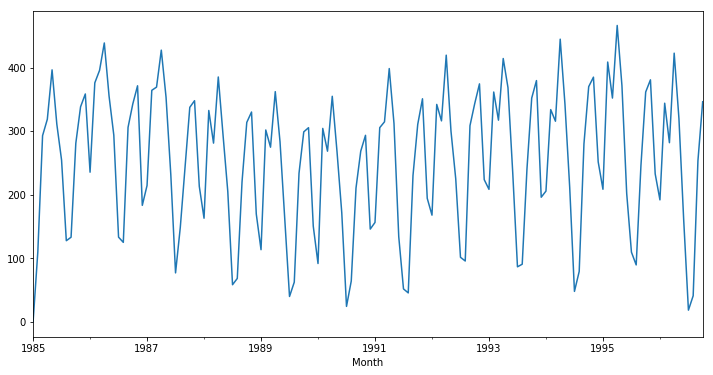

In [16]:
best_model.fittedvalues.plot()

## 6. Визуализация результата

Визуализируем лучшую полученную модель. Не забудем выполнить обратное преобразование Бокса-Кокса. Обратное дифференцирование остается за функцией SARIMAX:

In [17]:
def invboxcox(y, lmbda):
    if lmbda != 0:
        return np.exp(np.log(lmbda*y + 1) / lmbda)
    else:
        return np.exp(y)

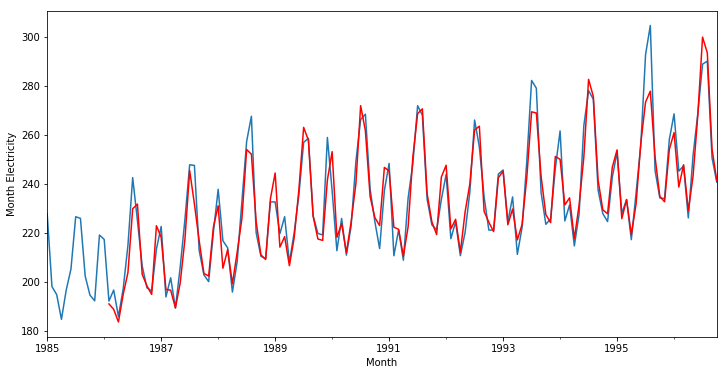

In [18]:
df['model'] = y_pred -invboxcox(best_model.fittedvalues, lmbda) + n
df['elctricty'].plot(figsize=(12,6))
df.model[13:].plot(color='r')
plt.ylabel('Month Electricity')
plt.show()

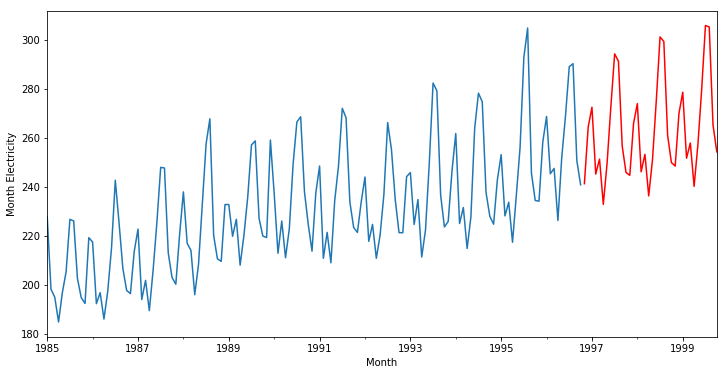

In [19]:
df.elctricty.plot(figsize=(12,6))
s=36
u = reg.predict(np.arange(X.shape[0]+1,X.shape[0]+1+s).reshape(-1,1)) - invboxcox(best_model.forecast(s), lmbda) + n
u.plot(color='r')
plt.ylabel('Month Electricity')
plt.show()